# Exploration of results from Bayesian modelling

We have run a hierarchical MCMC model to estimate galaxy pitch angle from clustered spiral arms obtained through the _Galaxy Builder_ citizen science project.

TODO: clean this up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.text import Annotation
from matplotlib import rc

import seaborn as sns
from scipy.optimize import minimize
import pymc3 as pm
from tqdm import tqdm
import scipy.stats as st
import corner
import warnings
from IPython.display import Latex
from gzbuilder_analysis import load_fit_results

warnings.simplefilter('ignore', UserWarning)

In [3]:
fit_results = load_fit_results('../gzbuilder_results/output_files/tuning_results', ext='pickle.gz')

In [4]:
fit_results.chisq.describe()

count    294.000000
mean       1.589997
std        0.765085
min        1.012060
25%        1.153419
50%        1.337545
75%        1.824268
max        8.493264
Name: chisq, dtype: float64

In [5]:
INPUT_FILE = 'n139d1000t500.pickle'

In [6]:
res = pd.read_pickle(INPUT_FILE)
bhsm = res['model']
trace = res['trace']

In [7]:
display(bhsm.model)

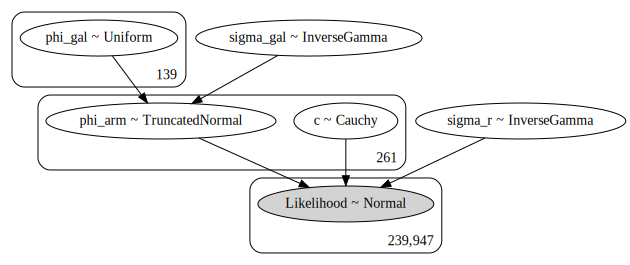

In [8]:
pm.model_to_graphviz(bhsm.model)

In [9]:
# pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
c[0],1.160,0.002,1.157,1.163,0.000,0.000,3910.0,3910.0,3924.0,1530.0,1.0
c[1],0.107,0.006,0.096,0.118,0.000,0.000,1666.0,1660.0,1662.0,1454.0,1.0
c[2],0.307,0.008,0.291,0.322,0.000,0.000,1955.0,1955.0,1954.0,1503.0,1.0
c[3],1.184,0.002,1.180,1.189,0.000,0.000,2762.0,2762.0,2770.0,1501.0,1.0
c[4],0.708,0.003,0.702,0.713,0.000,0.000,4406.0,4402.0,4383.0,1350.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
phi_arm[256],16.344,0.929,14.685,18.162,0.019,0.014,2360.0,2360.0,2368.0,1694.0,1.0
phi_arm[257],17.360,0.772,15.915,18.768,0.018,0.013,1893.0,1890.0,1895.0,1640.0,1.0
phi_arm[258],29.910,0.908,28.183,31.607,0.017,0.012,2901.0,2901.0,2907.0,1759.0,1.0
phi_arm[259],44.106,1.560,41.212,46.919,0.037,0.026,1734.0,1734.0,1743.0,1657.0,1.0


In [15]:
def get_r(sample):
    b = np.tan(np.pi / 180 * sample['phi_arm'])
    return np.exp(
        b[bhsm.data['arm_index'].values] * bhsm.data['theta']
        + sample['c'][bhsm.data['arm_index'].values]
    )

We can use the [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) ($R^2$) as a measure of the predictive power of the model:

In [16]:
from sklearn.metrics import r2_score

r2_scores = np.fromiter(
    (r2_score(bhsm.data['r'].values, get_r(sample)) for sample in np.random.choice(trace, 1000)),
    dtype=float,
    count=1000,
)

display(Latex('$R^2(samples) = {:.4f} ± {:.4f}$'.format(r2_scores.mean(), r2_scores.std())))

Eb = np.array(np.tan(np.pi / 180 * trace.phi_arm.mean(axis=0)))
Er = np.exp(
    Eb[bhsm.data['arm_index'].values] * bhsm.data['theta']
    + trace.c.mean(axis=0)[bhsm.data['arm_index'].values]
)
Er2_score = r2_score(bhsm.data['r'].values, Er)
display(Latex('$R^2(\mathrm{{expectation}}) = {:.4f}$'.format(Er2_score)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We see that the model fits the data well, with a relatively high $R^2$ score of ~0.86

In [17]:
gal_pa_samples = pd.DataFrame(
    trace['phi_gal'].T,
    index=bhsm.galaxies.index
)
pa_expectation = gal_pa_samples.mean(axis=1)
pa_std = gal_pa_samples.std(axis=1)

print('N Galaxies:', len(res['model'].galaxies))
print('N Arms:    ', res['model'].n_arms)
print('N Points:  ', res['model'].data.shape[0])

N Galaxies: 139
N Arms:     261
N Points:   239947


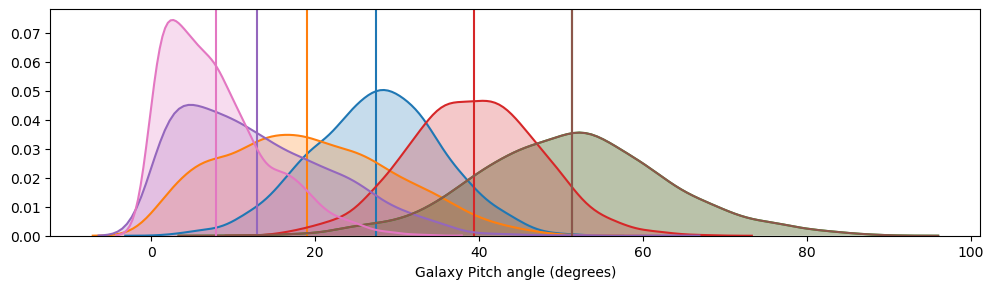

In [18]:
plt.figure(figsize=(12, 3), dpi=100)
sample = pa_expectation.sample(5)
for i, idx in enumerate(sample.index.values.tolist() + [pa_expectation.idxmax(), pa_expectation.idxmin()]):
    sns.kdeplot((gal_pa_samples.loc[idx]), shade=True, color=f'C{i}')
    plt.axvline(gal_pa_samples.loc[idx].mean(), color=f'C{i}')
# i = (gal_pa_samples.idxmax(), gal_pa_samples.idxmin())
plt.xlabel('Galaxy Pitch angle (degrees)')
plt.gca().get_legend().remove()
plt.savefig('plots/gal_pa_kde_sample.png', bbox_inches='tight')

What is the uncertainty on our estimate of arm pitch angles ($\sigma_{\phi_\mathrm{arm}})$? And on $\sigma_\mathrm{gal}$, the measure of inter-arm pitch angle variation?

In [19]:
from IPython.display import Latex

arm_uncertainty = trace.phi_arm.std(axis=0)

display(Latex(r'$\sigma_{{\phi_\mathrm{{arm}}}} = {:.2f} ± {:.2f}$'.format(arm_uncertainty.mean(), arm_uncertainty.std())))
display(Latex(r'$\sigma_\mathrm{{gal}} = {:.2f} ± {:.2f}$'.format(trace.sigma_gal.mean(), trace.sigma_gal.std())))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

What is our uncertainty on the galaxy's pitch angle relative to the number of arms identified?

n_arms,1,2,3,4
Err,9.86,7.90,6.77,5.95
Expected,11.02,7.79,6.36,5.51


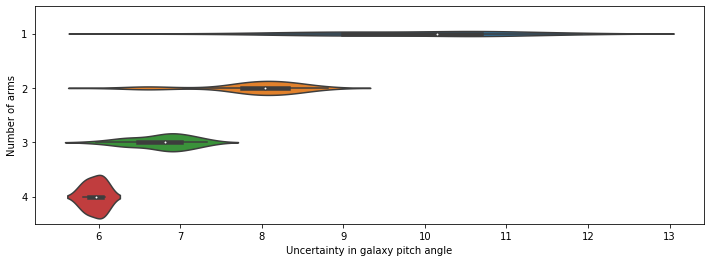

In [20]:
plt.figure(figsize=(12, 4))
sns.violinplot(pa_std, bhsm.galaxies.apply(len), orient='horizontal')
plt.xlabel('Uncertainty in galaxy pitch angle')
plt.ylabel('Number of arms')
plt.savefig('plots/error_vs_n_arms.png', bbox_inches='tight')

display(
    pd.concat((
        pa_std,
        bhsm.galaxies.apply(len)
    ), axis=1)
    .rename(columns={0: 'Err', 1: 'n_arms'})
    .groupby('n_arms')
    .mean()
    .assign(Expected=pd.Series([trace.sigma_gal.mean() / np.sqrt(i) for i in range(1, 5)], index=range(1, 5)))
    .T.round(2)
)

What does our model predict for inter-arm variance?

## Comparison to length-weighted pitch angles

Let's get some values for the length-weighted pitch angle of our galaxies:

In [21]:
# sample extraction
galaxies_df = pd.read_pickle('lib/merged_arms.pickle')
# keep only galaxies with one arm or more
galaxies_df = galaxies_df[galaxies_df.notna().any(axis=1)]
pa_lw_mean = galaxies_df.apply(
    lambda row: row['pipeline'].get_pitch_angle(row.drop('pipeline').dropna().values)[0],
    axis=1
).reindex_like(galaxies_df)

def get_err(row):
    return row.dropna()\
      .drop('pipeline')\
      .apply(lambda arm: arm.pa)\
      .std()
pa_lw_err = galaxies_df.apply(get_err, axis=1).reindex_like(galaxies_df).fillna(0)
print('Total number of galaxies:', len(pa_lw_err))

Total number of galaxies: 139


Text(0, 0.5, '$E[\\phi_\\mathrm{gal}]$')

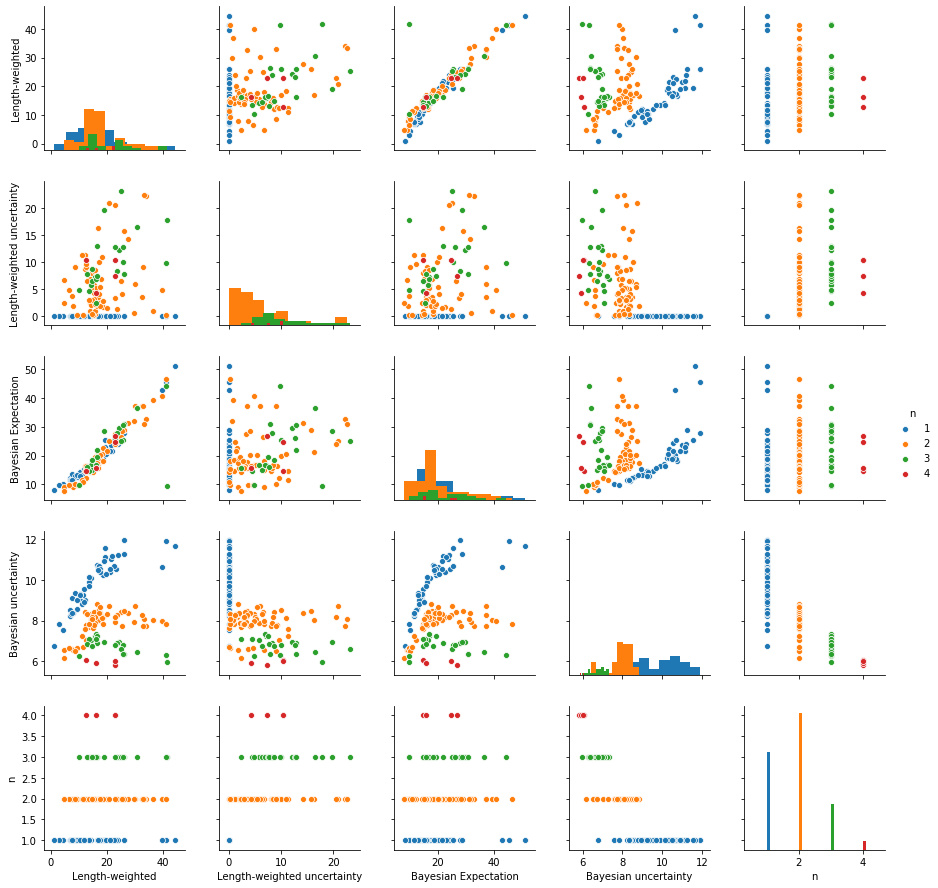

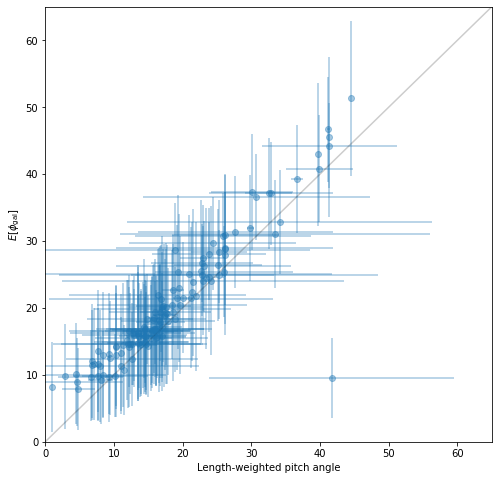

In [22]:
lw_df = pd.concat((
    pa_lw_mean.dropna().rename('lw'),
    pa_lw_err.rename('lw_err'),
    pa_expectation.rename('E'),
    pa_std.rename('E_err'),
    bhsm.galaxies.apply(len).rename('n'),
), axis=1).dropna()

g = sns.pairplot(
    lw_df.rename(columns=dict(
        lw='Length-weighted',
        lw_err='Length-weighted uncertainty',
        E='Bayesian Expectation',
        E_err='Bayesian uncertainty',
    )),
    hue='n', diag_kind='hist'
)

plt.figure(figsize=(8, 8))
plt.errorbar(
    lw_df['lw'], lw_df['E'],
    xerr=lw_df['lw_err'], yerr=lw_df['E_err'],
    fmt='o', alpha=0.4
)
plt.plot((0, 90), (0, 90), c='k', alpha=0.2)
plt.xlim(0, 65)
plt.ylim(0, 65)
plt.xlabel('Length-weighted pitch angle')
plt.ylabel(r'$E[\phi_\mathrm{gal}]$')

The values are very consistent, as would be expected. However the measure of error generally used with length-weighted pitch angle measurement (sample error of arm segment pitch angle), does not provide as robust a measurement as the error in the posterior we obtain for $\phi_\mathrm{gal}$.

# Examination of arm pitch angle spread

In [23]:
n_arm_map = pd.Series(bhsm.gal_n_arms, index=bhsm.galaxies.index)

arm_pa_samples = pd.DataFrame(trace['phi_arm'].T, index=pd.MultiIndex.from_tuples([
    (i, j)
    for i in gal_pa_samples.index
    for j in range(n_arm_map.loc[i])
]))
arm_mean_pas = arm_pa_samples.mean(axis=1)

In [24]:
gal_mean_pas = gal_pa_samples.mean(axis=1).loc[arm_mean_pas.index.get_level_values(0)]
gal_mean_pas.index = arm_mean_pas.index

offset_samples = (arm_pa_samples - gal_pa_samples.loc[arm_mean_pas.index.get_level_values(0)].values)
offset_mean = offset_samples.mean(axis=1)
offset_std = offset_samples.std(axis=1)

n_arms = pd.Series(bhsm.gal_n_arms, index=bhsm.galaxies.index).loc[arm_mean_pas.index.get_level_values(0)]
n_arms.index = arm_mean_pas.index

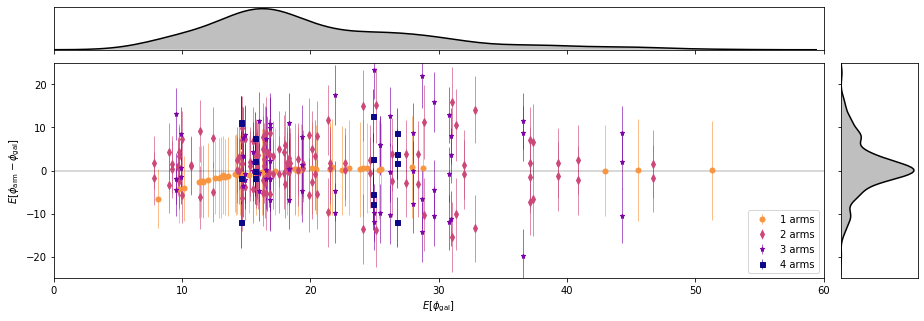

In [25]:
from matplotlib import cm

fig, ((pa_kd, null_ax), (scatter_ax, delta_kd)) = plt.subplots(
    2, 2,
    gridspec_kw={'width_ratios': [10, 1], 'height_ratios': [1, 5]},
    figsize=(12, 5),
    sharex='col',
    sharey='row'
)

sns.kdeplot(gal_mean_pas, ax=pa_kd, shade=True, color='k')
pa_kd.set_yticks([])
null_ax.axis('off')
plt.sca(scatter_ax)

formats = ('o', 'd', '*', 's', 'p')
for i in np.unique(n_arms):
    plt.errorbar(
        gal_mean_pas[n_arms == i],
        offset_mean[n_arms == i],
    #     xerr=gal_std_pas,
        yerr=offset_std[n_arms == i],
        fmt=formats[i-1],
#         c='C{}'.format(i),
        c=cm.plasma(1-i/4),
        ms=5,
        elinewidth=0.6,
        label=f'{i} arms',
    )
plt.gca().add_line(plt.Line2D((0, 90), (0, 0), c='k', alpha=0.2))
plt.xlim(0, 60)
d = 25
plt.ylim(-d, d)
plt.xlabel(r'$E[\phi_\mathrm{gal}]$')
plt.ylabel('$E[\phi_\mathrm{arm} - \phi_\mathrm{gal}]$');
plt.legend(loc='lower right')
plt.sca(delta_kd)
sns.kdeplot(offset_mean, ax=delta_kd, vertical=True, shade=True, color='k')
delta_kd.set_xticks([])
plt.subplots_adjust(hspace=0.1, wspace=0.04, left=0, right=1)
plt.savefig('plots/arm_pa_spread.pdf', bbox_inches='tight')
plt.savefig('plots/arm_pa_spread.png', bbox_inches='tight')

## Comparison to GZ2 and Hart (2017)

In [26]:
gz2_spiral_data = pd.read_csv('lib/gz2_spiral_data.csv', index_col=0)

hart_catalog = pd.read_csv('../source_files/Hart2017/psi_table.csv', index_col=0)
subject_metadata = pd.read_csv('lib/galaxy-builder-subjects.csv', index_col=0).metadata.apply(json.loads).apply(pd.Series)

dr7objid_map = subject_metadata['SDSS dr7 id']\
    .rename('dr7objid')\
    .dropna()\
    .astype(np.int64)\
    .drop_duplicates()\
    .reset_index()\
    .set_index('dr7objid')\
    .reindex(hart_catalog.index)\
    .dropna()

hart_catalog = hart_catalog.assign(subject_id=dr7objid_map).dropna().reset_index().set_index('subject_id').replace(-999, np.nan)

We can double-check the matching has worked by comparing the positions:

In [27]:
from astropy import units as u
from astropy.coordinates import SkyCoord
foo = pd.concat((
    subject_metadata[['ra', 'dec']].drop_duplicates().reindex(hart_catalog.index),
    hart_catalog[['ra', 'dec']].add_suffix('_hart')
), axis=1).astype(float)

def foo_func(row):
    c0 = SkyCoord(row['ra'] * u.degree, row['dec'] * u.degree, frame='fk5')
    c1 = SkyCoord(row['ra_hart'] * u.degree, row['dec_hart'] * u.degree, frame='fk5')
    return c0.separation(c1).arcsecond
display(foo.apply(foo_func, axis=1).describe().rename('Match offset (arcseconds)'))
del foo

count    198.000000
mean       0.008249
std        0.005910
min        0.000000
25%        0.003578
50%        0.007257
75%        0.010884
max        0.050399
Name: Match offset (arcseconds), dtype: float64

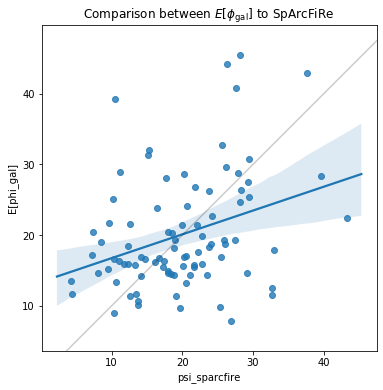

In [28]:
plt.figure(figsize=(6, 6))
sns.regplot('psi_sparcfire', 'E[phi_gal]', pd.concat((hart_catalog, pa_expectation.rename('E[phi_gal]')), axis=1))
plt.axis('equal')
plt.title(r'Comparison between $E[\phi_\mathrm{gal}]$ to SpArcFiRe')
plt.gca().add_line(plt.Line2D((0, 90), (0, 90), c='k', alpha=0.2))

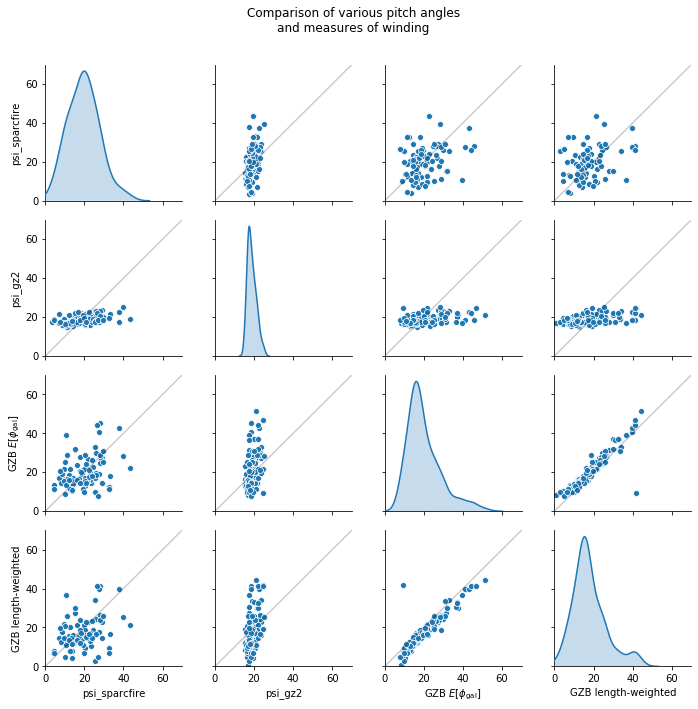

In [29]:
g = sns.pairplot(
    pd.concat((
        hart_catalog[['psi_sparcfire', 'psi_gz2']],
        pa_expectation.rename(r'GZB $E[\phi_\mathrm{gal}]$'),
        pa_lw_mean.rename('GZB length-weighted'),
#         gz2_spiral_data['winding'].rename('GZ2 winding coefficient'),
    ), axis=1),
#     kind='reg',
    diag_kind='kde',
)

def foo(ax):
    ax.add_line(plt.Line2D((0, 90), (0, 90), c='k', alpha=0.2))

[foo(ax) for i, row in enumerate(g.axes) for j, ax in enumerate(row) if i != j and i < 4]
[a.set_xlim(0, 70) for a in g.axes[-1]]
[a.set_ylim(0, 70) for a in g.axes[:, -1]]
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Comparison of various pitch angles\nand measures of winding');

In [30]:
def set_color_by_correlation(row, cmap=cm.get_cmap('RdYlGn', 12)):
    values = (np.array([cmap((value + 1) / 2) for value in row])  * [256, 256, 256, 1]).astype(int)
    return [f'background-color: rgba{tuple(value.tolist())}' for value in values]

In [31]:
pd.concat((
    gz2_spiral_data['winding'].rename('GZ2 Winding coefficient'),
    hart_catalog[['psi_sparcfire', 'psi_gz2']],
    pa_expectation.rename('Expectation'),
    pa_lw_mean.rename('Length-weighted'),
), axis=1).corr().style.apply(set_color_by_correlation)

,GZ2 Winding coefficient,psi_sparcfire,psi_gz2,Expectation,Length-weighted
GZ2 Winding coefficient,1.000000,0.480005,0.985303,0.423992,0.418452
psi_sparcfire,0.480005,1.000000,0.474376,0.329570,0.331413
psi_gz2,0.985303,0.474376,1.000000,0.411705,0.468560
Expectation,0.423992,0.329570,0.411705,1.000000,0.914848
Length-weighted,0.418452,0.331413,0.468560,0.914848,1.000000
